In [1]:
import gzip
import random
from n_gram import Ngram
from backoff import Backoff
from weighted import LearnedWeighted
from utils import run_model, compress, decompress
import numpy as np
from testing_models import get_random_enwik
from coding import get_bytes_to_write
import torch
import torch.nn as nn
from tqdm import tqdm

In [16]:
m = nn.TransformerEncoderLayer(64,2,64)

In [18]:
inp = torch.randn(1,64)
m(inp).shape

torch.Size([1, 64])

In [49]:
class NN(nn.Module):
    def __init__(self, n, n_layers, h_dim):
        super().__init__()
        self.inp_layer = nn.Linear(n, h_dim)
        layers = []
        for i in range(n_layers):
            layers.append(nn.Linear(h_dim, h_dim))
            layers.append(nn.ReLU())
        self.h_layers = nn.Sequential(*layers)
        self.out_layer = nn.Linear(h_dim, 2)
        self.relu = nn.ReLU()
        self.sofmax = nn.Softmax(1)
    def forward(self, x):
        x = self.relu(self.inp_layer(x))
        x = self.h_layers(x)
        x = self.out_layer(x)
        x = self.sofmax(x)
        return x

class Transformer(nn.Module):
    def __init__(self, n, n_layers, h_dim):
        super().__init__()
        self.inp_layer = nn.Linear(n, h_dim)
        self.t_encoder = nn.TransformerEncoderLayer(h_dim,n_layers,h_dim)
        self.out_layer = nn.Linear(h_dim, 2)
        self.relu = nn.ReLU()
        self.sofmax = nn.Softmax(1)
    def forward(self, x):
        x = self.relu(self.inp_layer(x))
        x = self.t_encoder(x)
        x = self.relu(x)
        x = self.out_layer(x)
        x = self.sofmax(x)
        return x

In [33]:
# neural_net = NN(4, 1, 16)
neural_net = Transformer(4, 1, 16)

In [34]:
inp = torch.tensor([[1.0,0,1,0]])

In [35]:
inp

tensor([[1., 0., 1., 0.]])

In [36]:
neural_net(inp)

tensor([[0.5009, 0.4991]], grad_fn=<SoftmaxBackward0>)

In [63]:
class Model:
    def __init__(self, n):
        self.n = n
#         self.nn = NN(n, 1, 128)
        self.nn = Transformer(n, 2, 128)
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.nn.to(self.device)
        self.lr = 1e-4
        self.optimizer = torch.optim.Adam(self.nn.parameters(), self.lr)
        self.context = [0.] * n
        self.temp_prob = None
    
    def get_prob(self):
        inp = torch.tensor([self.context], device=self.device)
        out = self.nn(inp)
        self.temp_prob = out
        return out[0][0].item()
    
    def update(self, bit):
        if bit == '1':
            loss = torch.log2(1 / ( self.temp_prob[0][1]))
        if bit == '0':
            loss = torch.log2(1 / (self.temp_prob[0][0]))
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        
        self.context += [1.] if bit == '1' else [0.]
        self.context = self.context[-self.n:]
    
    def reset(self):
        pass

In [58]:
data = get_random_enwik(int(1e3))

In [64]:
model = Model(128)

In [65]:
compressed_data, theo = compress(model, data)
compressed_data = get_bytes_to_write(compressed_data)

In [66]:
len(data), len(compressed_data)

(1000, 776)

In [67]:
data = get_random_enwik(int(1e3))

In [68]:
# l = []
for i in tqdm(range(8, 500, 8)):
    model = Model(i)
    compressed_data, theo = compress(model, data)
    compressed_data = get_bytes_to_write(compressed_data)
    l.append(len(compressed_data))

  0%|                                                    | 0/62 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [37]:
import matplotlib.pyplot as plt

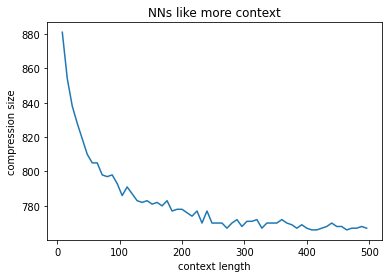

In [52]:
plt.plot(range(8, 500, 8), l)
plt.xlabel('context length')
plt.ylabel('compression size')
plt.title('NNs like more context')
plt.savefig('files/NN_like_more_context.jpg', dpi=200)
plt.show()